A partir du fichier téléchargé depuis ActiveTiggers, il faut passer par description_annotations pour créer le fichier avec la phrase, l'id et l'annotation.

In [1]:
import numpy as np
import random
import torch
import sklearn
random_seed = 1968
# Set random seed for NumPy
np.random.seed(random_seed)

# Set random seed for Python built-in random module
random.seed(random_seed)

# Set random seed for PyTorch
torch.manual_seed(random_seed)

# Set random seed for Scikit-learn
sklearn.utils.check_random_state(random_seed)


RandomState(MT19937) at 0x29511C39D40

# Preping annotations

In [2]:
import pandas as pd

current_annotations_file = "../../data/intermediate/annotations/personne_withSentence_1400annotations_2024-07-15_ActiveTigger.csv"

annotations_file = pd.read_csv(current_annotations_file, dtype = {'sentence_id':'int', 
'Personne':'str','sentence':'str'}).set_index('sentence_id')

recat = {
    "Corps humain":"Corps humain",
    "Genre/espèce humaine":"Genre/espèce humaine",
    "Individu ou sujet" : "Individu ou sujet",
    "Personne à protéger":"Personne juridique (protection/responsabilité)",
    "Personne responsable et autonome":"Personne juridique (protection/responsabilité)",
    "Personne relationnelle":"Personne relationnelle",
    "Sentiment humain":"Sentiment humain",
    "Poubelle" : "Poubelle"
}

frecat = lambda x: recat[x]
annotations_file['Personne'] = annotations_file["Personne"].apply(frecat)

annotations_file.head(5)

,Personne,sentence
sentence_id,,
1220587,Personne juridique (protection/responsabilité),Il importe donc de tenir compte de toutes les ...
1291195,Personne juridique (protection/responsabilité),Le principe fondamental d’une garantie humaine...
1360306,Personne juridique (protection/responsabilité),Ces personnes donnent un consentement qui relè...
580205,Personne juridique (protection/responsabilité),"Sur le plan éthique, cette évolution peut être..."
700014,Personne juridique (protection/responsabilité),C'est dans ce cadre que peut se\nposer la ques...


In [3]:
system_prompt = """Tu es un expert en éthique qui doit classifier des phrases présentes dans les textes d'un comité de bioéthique. Le but est de comprendre le traitement de la personne/de l'individu/de l'humain dans ces questionnements éthiques. 
Tu dois classifier une phrase en français parmi l'une des catégories suivantes : Corps humain, Genre/espèce humaine, Individu ou sujet, Personne à protéger, Personne relationnelle, Personne responsable et autonome, Poubelle, Sentiment humain. 
Ne fais pas une phrase complète, ni ne donne de justification, juste donne l'intitulé de la catégorie.
Voici une courte description de chaque catégorie :
Corps humain = tout ce qui réfère directement au corps humain, comme le matériel biologique, des explications biologiques ou les débats autour du statut de l'embryon.
Genre/espèce humaine = tout ce qui relève de ce que l'humanité partage en commun, le fait d'être un être humain et de ce que l'humanité partage avec le reste du vivant, en particulier mais pas que les questions d'écologie.
Individu ou sujet = tout ce qui relève de la statistique, ou de l'économie, compter les gens, faire des essais en double aveugle, ou en parler comme d'une population à gérer, ou les calculs bénéfices risques. Par exemple, la gestion des prisons fait partie de cette catégorie, ou encore la gestion du système de santé. Cette catégorie inclut aussi les cas où la raison publique est supérieure à l'individu ou certaines questions de gestion d'épidémie.
Personne à protéger = tout ce qui relève de l'idée de protection de la personne, en particulier dans un sens médical. Le médecin est responsable du patient, et pas le patient de lui-même. Cela inclut par exemple mais pas seulement : le respect de la personne, ou le fait de la protéger contre son manque d'autonomie, ou encore le fait de faire respecter le droit de la personne.
Personne responsable et autonome = tout ce qui relève de conserver l'autonomie de la personne ou de traiter la personne comme un agent responsable de ses actes, en particulier une responsabilité juridique (comme une personne qui doit donner son consentement). S'applique aussi quand la personne est capable de se déterminer grâce à l'entourage, grâce à ses relations par exemple avec le personnel médical.
Personne relationnelle = quand la personne est définie par son entourage, ou quand son entourage est important. Par exemple, si on parle d'une personne de confiance ou collégialité. Cette catégorie est aussi une catégorie intermédiaire entre personne à protéger et personne responsable et autonome.
Sentiment humain = catégorie plus rare mais importante qui inclut les cas où ce sont les sentiments que nous éprouvons en tant qu'humain qui sont importants comme la dignité, l'empathie.
Poubelle = catégorie à utiliser si et seulement si le texte ne réfère pas à la personne (erreur de frappe comme personne l ou personne lle).
Si une incertitude persiste, concentre-toi moins sur le contexte de la phrase que sur la façon dont la personne est envisagée dans la phrase.
"""
user_prompt = """
A quelle catégorie appartient la phrase que je te donne parmi les catégories suivantes : Corps humain, Genre/espèce humaine, Individu ou sujet, Personne à protéger, Personne relationnelle, Personne responsable et autonome, Poubelle, Sentiment humain. 
Ne fais pas une phrase complète, ni ne donne de justification, juste donne l'intitulé de la catégorie.
La phrase à classifier est la suivante :

"""
print(system_prompt)
print(user_prompt)

Tu es un expert en éthique qui doit classifier des phrases présentes dans les textes d'un comité de bioéthique. Le but est de comprendre le traitement de la personne/de l'individu/de l'humain dans ces questionnements éthiques. 
Tu dois classifier une phrase en français parmi l'une des catégories suivantes : Corps humain, Genre/espèce humaine, Individu ou sujet, Personne à protéger, Personne relationnelle, Personne responsable et autonome, Poubelle, Sentiment humain. 
Ne fais pas une phrase complète, ni ne donne de justification, juste donne l'intitulé de la catégorie.
Voici une courte description de chaque catégorie :
Corps humain = tout ce qui réfère directement au corps humain, comme le matériel biologique, des explications biologiques ou les débats autour du statut de l'embryon.
Genre/espèce humaine = tout ce qui relève de ce que l'humanité partage en commun, le fait d'être un être humain et de ce que l'humanité partage avec le reste du vivant, en particulier mais pas que les questi

In [4]:
# Step 1: Concatenate user_prompt with sentence
annotations_file['full_question'] = "Pour la phrase d'identifiant id:" + annotations_file.index.astype(str) + ';\n' + user_prompt + '\n' + annotations_file['sentence']

annotations_file.sample(5)


,Personne,sentence,full_question
sentence_id,,,
1290246,Genre/espèce humaine,De véritables sauts qualitatifs sont en \ncour...,Pour la phrase d'identifiant id:1290246;\n\nA ...
1430748,Personne relationnelle,La personne de confiance pourrait \nd’ailleurs...,Pour la phrase d'identifiant id:1430748;\n\nA ...
1420173,Personne juridique (protection/responsabilité),- La difficul té à subir des examens pour les ...,Pour la phrase d'identifiant id:1420173;\n\nA ...
220007,Corps humain,"Seule, la thérapie génique somatique (1) peut\...",Pour la phrase d'identifiant id:220007;\n\nA q...
110038,Personne juridique (protection/responsabilité),Sujets humains étudiés\nPlutôt que de proposer...,Pour la phrase d'identifiant id:110038;\n\nA q...


# Export jsonl

In [5]:
from sklearn.model_selection import train_test_split

resave = True
# Step 2: Separate train and test split, stratifying by annotation categories
train, test = train_test_split(annotations_file[["full_question","Personne"]], 
                               stratify=annotations_file['Personne'], random_state=random_seed)

def dataframe_to_json(system_prompt, dataframe):
    json_data = []
    for _, row in dataframe.iterrows():
        messages = []
        messages.append({"role": "system", "content": system_prompt})
        messages.append({"role": "user", "content": row['full_question']})
        messages.append({"role": "assistant", "content": row['Personne']})
        json_data.append({"messages": messages})
    return json_data

train_json = dataframe_to_json(system_prompt=system_prompt,dataframe=train)
test_json = dataframe_to_json(system_prompt=system_prompt,dataframe=test)

import json

if resave:
    # Save train_json
    with open('../../data/intermediate/gpt/train.jsonl', 'w') as f:
        for item in train_json:
            json.dump(item, f)
            f.write('\n')

    # Save test_json
    with open('../../data/intermediate/gpt/test.jsonl', 'w') as f:
        for item in test_json:
            json.dump(item, f)
            f.write('\n')


# redo test and confusion matrix    

In [6]:
test.sample()

,full_question,Personne
sentence_id,,
790295,Pour la phrase d'identifiant id:790295;\n\nA q...,Personne relationnelle


In [8]:
from openai import OpenAI
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rerun = False

# Set up your OpenAI API key
client = OpenAI(
    api_key = ""
)

# Load your test set
texts = test['full_question'].tolist()
true_labels = test['Personne'].tolist()

# Get unique labels from true labels
unique_labels = list(pd.Series(true_labels).unique())
unique_labels.append("Miscellaneous")

# Function to get predictions from the fine-tuned model
def get_predictions(texts):
    predictions = []
    full_responses = []
    for text in texts:
        response =  client.chat.completions.create(
            model="ft:gpt-3.5-turbo-0125:cmh:ccne-per-sd1968-6c:9p0TvPpS",
            messages = [
                {'role': "system", 'content':system_prompt},
                {'role': "user", 'content':text}
            ]
        )
        full_responses.append(response)
        prediction = response.choices[0].message.content
        predictions.append(prediction)
    return predictions, full_responses

# Get predictions
if rerun:
    predicted_labels, full_responses = get_predictions(texts)
else:
    test = pd.read_pickle('../../data/intermediate/gpt/2023_07_25_seed1968_CCNE_pers_gpt_test_with_predictions.pkl')
    predicted_labels = test["Predicted_Label"]
    full_responses = test["Full_response"]

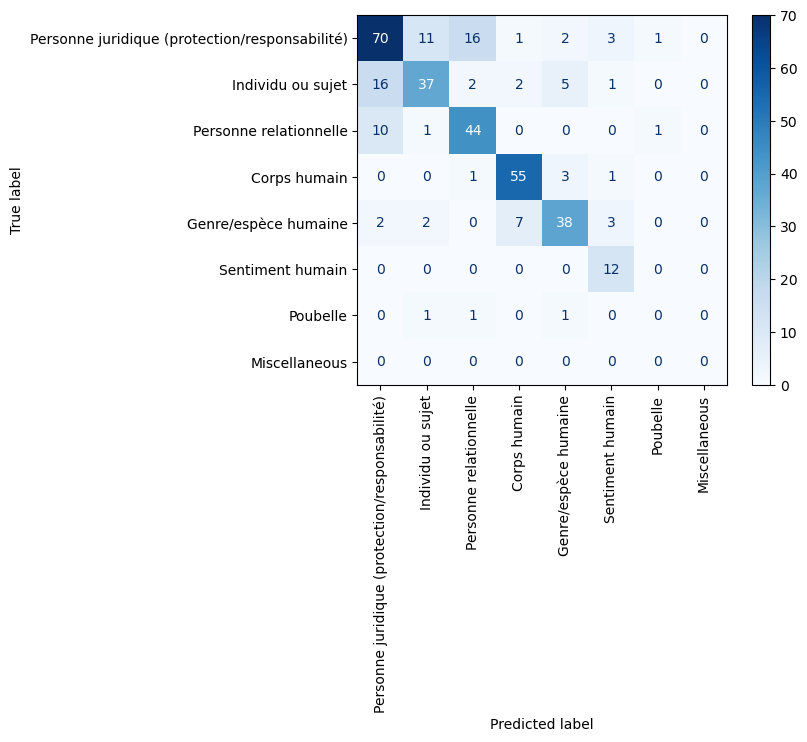

In [9]:
# Handle miscellaneous predictions
corrected_predictions = [
    prediction if prediction in unique_labels else "Miscellaneous"
    for prediction in predicted_labels
]

# Create confusion matrix
cm = confusion_matrix(true_labels, corrected_predictions, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [10]:
# Add predictions to the DataFrame
test['Predicted_Label'] = predicted_labels
test['Corrected_Prediction'] = corrected_predictions
test['Full_response'] = full_responses

# Save the DataFrame as a .pkl file
if rerun:
    test.to_pickle('../../data/intermediate/gpt/2023_07_25_seed1968_CCNE_pers_gpt_test_with_predictions.pkl')

In [11]:
pd.set_option('display.max_colwidth', None)

cat_a_corriger = "Corps humain"

test[(test['Corrected_Prediction']!=cat_a_corriger) & (test['Personne']==cat_a_corriger)].join(annotations_file[["sentence"]])[
    ["Corrected_Prediction","sentence"]
    ]

,Corrected_Prediction,sentence
sentence_id,,
20557,Genre/espèce humaine,"Ces études englobent non seulement des interventions planifiées sur des sujets humains,\nmais des recherches dans lesquelles des facteurs environnementaux sont manipulés d'une\nmanière pouvant constituer un risque pour des individus exposés fortuitement."
1330004,Genre/espèce humaine,"Ces capacités \ninédites des biotechnologies peuvent être perçues comme une voie prometteuse pour \nmieux comprendre le rôle des gènes, la signification des variations observées entre \nindividus, notamment en regard de leur état de santé et, plus généralement, de nouvelles \npossibilités pour réparer le génome (dans le cas de l’homme) ou pour une domestication \nmieux adaptée aux besoins de l’humanité (dans le cas des plantes et des animaux)."
1140224,Sentiment humain,"Notre société est sensible aux valeurs qui \ntouchent à l’intimité : pudeur, indisponibilité et intégrité du corps humain."
820419,Genre/espèce humaine,La structure du visage humain est en effet très différente de la gueule de l’animal.
1240498,Personne relationnelle,"Quand un séquençage \nglobal d’ADN est décidé , un protocole rigoureux \ndoit guider la conduite à tenir pour les déco uvertes non sollicitées.83 \nLa Commission présidentielle pour l’étude des questions de bioéthique aux États -Unis et la S ociété européenne de génétique humaine rappellent la nécessité d’entreprendre une démarche de \ndécision partagée avec les patients au sujet du périmètre de la comm unication d es résultat s des \nexamen s génétiques et des modalités à mettre en œuvre en cas de découvertes incidentes."


In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Assuming 'test' is your DataFrame containing the true and predicted labels

# Calculate overall metrics
accuracy = accuracy_score(test['Personne'], test['Corrected_Prediction'])
f1 = f1_score(test['Personne'], test['Corrected_Prediction'], average='weighted')
precision = precision_score(test['Personne'], test['Corrected_Prediction'], average='weighted')
recall = recall_score(test['Personne'], test['Corrected_Prediction'], average='weighted')

# Print overall metrics
print("Overall Metrics:")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}\n")

# Calculate metrics for each category
unique_labels = test['Personne'].unique()
f1_per_category = f1_score(test['Personne'], test['Corrected_Prediction'], average=None, labels=unique_labels)
precision_per_category = precision_score(test['Personne'], test['Corrected_Prediction'], average=None, labels=unique_labels)
recall_per_category = recall_score(test['Personne'], test['Corrected_Prediction'], average=None, labels=unique_labels)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame({
    'Category': unique_labels,
    'Precision': precision_per_category,
    'Recall': recall_per_category,
    'F1-Score': f1_per_category})

# Display the DataFrame
print(metrics_df)


Overall Metrics:
Accuracy: 0.7314285714285714
F1 Score: 0.7274677654100814
Precision: 0.7311668535546086
Recall: 0.7314285714285714

                                         Category  Precision    Recall  \
0  Personne juridique (protection/responsabilité)   0.714286  0.673077   
1                               Individu ou sujet   0.711538  0.587302   
2                          Personne relationnelle   0.687500  0.785714   
3                                    Corps humain   0.846154  0.916667   
4                            Genre/espèce humaine   0.775510  0.730769   
5                                Sentiment humain   0.600000  1.000000   
6                                        Poubelle   0.000000  0.000000   

   F1-Score  
0  0.693069  
1  0.643478  
2  0.733333  
3  0.880000  
4  0.752475  
5  0.750000  
6  0.000000  


# Prediction

In [13]:
base_shuffled = pd.read_pickle("../../data/intermediate/base_shuffled.pkl")
base_shuffled.sentence_id = base_shuffled.sentence_id.apply(int)

base_shuffled.set_index('sentence_id', inplace= True)

base_shuffled.head(5)

,sentence_text,sentence,personne,humain,individu,Titre,Date,president,rapporteurs,membres_gt,theme,saisine,divergence,CNPEN,tableaux et graphiques,nb_mots,number_sentences,nb_pages,sentence_index,num
sentence_id,,,,,,,,,,,,,,,,,,,,
770722,"Avec l’accumulation de grandes quantités de données à des\nfins de recherche biomédicale, s’ouvre un nouveau champ de problèmes\ntouchant aux questions de solidarité, d’altruisme et de justice. Le principe de la noncommercialisation du corps humain, en vigueur dans\nde nombreux pays et que reconnaissent la France et l’Allemagne interdit\npour des raisons qui dépassent largement le problème des biobanques, de\nmettre des éléments de son corps à la disposition d’autrui contre\nrémunération. Mais les deux comités ont évoqué une question parfois posée\nsur le plan international qui est celle du partage des bienfaits — certains\ndiraient même des bénéfices — résultant de l’activité de collecte et de\nconservation.","Le principe de la noncommercialisation du corps humain, en vigueur dans\nde nombreux pays et que reconnaissent la France et l’Allemagne interdit\npour des raisons qui dépassent largement le problème des biobanques, de\nmettre des éléments de son corps à la disposition d’autrui contre\nrémunération.",False,True,False,Problèmes éthiques posés par les collections de matériel biologique et les données d'information associées,2003-03-20,Sicard (00-08),"Hélène Gaumont-Prat,Nicole Questiaux,Gérard Orth","Nicole Baumann,Anne Cambon-Thomsen,Monique Canto-Sperber, Blandine Kriegel,Martine Loizeau,Sadek Béloucif, Gérard Bréart",Société,False,False,False,1,22196,730,51,722,77
930350,"Le critère du consentement : le consentement peuti l rendre commercialisable ce qui ne \ndevrait pas l’être ? Dans la mesure où le matériel biologique brut est d onné par une personne et peut faire \nl’objet d’une utilisation indifférenciée, la questi on du consentement de la personne source à \nl’utilisation de ce qui vient de son propre corps e t à l’exploitation commerciale dont un \nproduit de son corps serait éventuellement l’objet, se pose de façon aiguë. 19 Toutefois, l’obtention d’un consentement au moment du don initial d’un matériel \nbiologique ne suffit pas à lever tous les problèmes éthiques.","Dans la mesure où le matériel biologique brut est d onné par une personne et peut faire \nl’objet d’une utilisation indifférenciée, la questi on du consentement de la personne source à \nl’utilisation de ce qui vient de son propre corps e t à l’exploitation commerciale dont un \nproduit de son corps serait éventuellement l’objet, se pose de façon aiguë.",True,False,False,Commercialisation des cellules souches humaines et autres lignées cellulaires,2006-06-22,Sicard (00-08),Monique Canto-Sperber,"Anne Cambon-Thomsen,Hélène Gaumont-Prat,Chantal Lebatard,Martine Loizeau,Jacqueline Mandelbaum,Carole Moquin-Pattey,Dominique Stoppa-Lyonnet,Jean-Claude Ameisen,Sadek Béloucif,Pierre Le Coz,Olivier de Dinechin,Alain Fischer,Jean-Louis Lorrain,Jacques Montagut,Philippe Rouvillois,Maxime Seligmann,Alain-Gérard Slama","Don, consentement",False,True,False,0,22028,703,40,350,93
1070205,"Notons, en outre, que si l’on considérait que prati quer une IMG constitue une forme de \nprévention, les dispositions légales relatives à l’ information de la parentèle devraient \ns’appliquer sans ambiguïté. Or, le Comité estime pr écisément que la catégorie de \n« prévention » est inappropriée lorsqu’elle vise à engager une personne testée à \ninformer sa parentèle des risques encourus par un e nfant non encore né.23 Dans tous les \ncas de figure, selon le CCNE, l’expression « préven ir une naissance » (à laquelle l’actuel \nCode de la santé publique aboutit à donner crédit) semble excessivement paradoxale. De ce que l’IMG (on pourrait en dire autant du tri embryonnaire) n’a pas pour but de \nprévenir stricto sensu les problèmes de santé de l’embryon, on ne saurait toutefois en \nconclure que l’évitement de la naissance de l’enfan t soit une 

In [14]:
# Step 1: Concatenate user_prompt with sentence
base_shuffled['full_question'] = "Pour la phrase d'identifiant id:" + base_shuffled.index.astype(str) + ';\n' + user_prompt + '\n' + base_shuffled['sentence']

base_shuffled['full_question'].sample(5)


sentence_id
770304                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Pour la phrase d'identifiant id:770304;\n\nA quelle catégorie appartient la phrase que je te donne parmi les catégories suivantes : Corps humain, Genre/espèce humaine, Individu ou suj

In [15]:
repredict = False
# Set up your OpenAI API key
client = OpenAI(
    api_key = ""
)

# Load your test set
texts = base_shuffled['full_question'].tolist()

# Get unique labels from true labels
unique_labels = list(pd.Series(true_labels).unique())
unique_labels.append("Miscellaneous")

# Function to get predictions from the fine-tuned model
def get_predictions(texts):
    predictions = []
    full_responses = []
    for text in texts:
        response =  client.chat.completions.create(
            model="ft:gpt-3.5-turbo-0125:cmh:ccne-per-sd1968-6c:9p0TvPpS",
            messages = [
                {'role': "system", 'content':system_prompt},
                {'role': "user", 'content':text}
            ]
        )
        full_responses.append(response)
        prediction = response.choices[0].message.content
        predictions.append(prediction)
    return predictions, full_responses

# Get predictions
if repredict:
    predicted_labels, full_responses = get_predictions(texts)

In [16]:
if repredict:
    corrected_predictions = [
        prediction if prediction in unique_labels else "Miscellaneous"
        for prediction in predicted_labels
    ]

    base_shuffled['Predicted_Label'] = predicted_labels
    base_shuffled['Corrected_Prediction'] = corrected_predictions
    base_shuffled['Full_response'] = full_responses

In [17]:
if repredict:
    annotations_file["Annotated_Label"] = annotations_file["Personne"]
    base_predicted = base_shuffled.join(annotations_file["Annotated_Label"], on = 'sentence_id', validate="one_to_one")
    base_predicted['Label'] = np.where(base_predicted['Annotated_Label'].isna(), base_predicted['Corrected_Prediction'], base_predicted['Annotated_Label'])
    base_predicted.to_pickle("../../data/intermediate/predictions/predictions_gpt35ft_1400annotations_6classes_2024-07-25.pkl")
    base_predicted.to_csv("../../data/intermediate/predictions/predictions_gpt35ft_1400annotations_6classes_2024-07-25.csv")